In [0]:
# Copyright 2018 Google LLC.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
# Install deps
!pip install -q -U tensor2tensor tensorflow

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import collections
import sys
import tempfile

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.rl import rl_trainer_lib
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry

# Other setup
Modes = tf.estimator.ModeKeys

prefix = "~/t2t_rl_data"
# Setup data directories
data_dir = os.path.expanduser(prefix + "/data")
tmp_dir = os.path.expanduser(prefix + "/tmp")
tf.gfile.MakeDirs(data_dir)
tf.gfile.MakeDirs(tmp_dir)

# Train policy

The training of the policy will take around 1h on GPU.

In [3]:
iteration_num=300
hparams = trainer_lib.create_hparams("atari_base", "epochs_num={}".format(iteration_num+1))
ppo_dir = tempfile.mkdtemp(dir=data_dir, prefix="ppo_")
rl_trainer_lib.train(hparams, "stacked_pong", ppo_dir)

INFO:tensorflow:Overriding hparams in atari_base with epochs_num=1


[2018-03-07 00:06:25,614] Overriding hparams in atari_base with epochs_num=1
[2018-03-07 00:06:25,620] Making new env: PongNoFrameskip-v4
[2018-03-07 00:06:25,860] Making new env: PongNoFrameskip-v4
[2018-03-07 00:06:25,865] Making new env: PongNoFrameskip-v4
[2018-03-07 00:06:25,872] Making new env: PongNoFrameskip-v4
[2018-03-07 00:06:25,883] Making new env: PongNoFrameskip-v4
[2018-03-07 00:06:25,892] Making new env: PongNoFrameskip-v4


Instructions for updating:
Use the `axis` argument instead


[2018-03-07 00:06:26,589] From /home/blazej.osinski/t2t/t2t_jupyter_kernel/local/lib/python2.7/site-packages/tensorflow/python/ops/distributions/categorical.py:310: calling argmax (from tensorflow.python.ops.math_ops) with dimension is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead
[2018-03-07 00:06:27,589] Making new env: PongNoFrameskip-v4
[2018-03-07 00:06:27,772] Making new env: PongNoFrameskip-v4
[2018-03-07 00:06:47,971] Starting new video recorder writing to /home/blazej.osinski/t2t_rl_data/data/ppo_Yr5Rjt/openaigym.video.0.144364.video000000.mp4
[2018-03-07 00:09:36,335] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/blazej.osinski/t2t_rl_data/data/ppo_Yr5Rjt')


In [4]:
model_path = os.path.join(ppo_dir, "model{}.ckpt.index".format(iteration_num))[:-6]

# Generate and review frames from policy

In [6]:
sys.argv = [sys.argv[0], "--model_path", model_path]

In [12]:
tf.reset_default_graph()

In [14]:
# This step is also time consuming - takes around 30 minutes.
gym_problem = problems.problem("gym_pong_trajectories_from_policy")
gym_problem.generate_data(data_dir, tmp_dir)

[2018-03-07 00:13:20,983] Making new env: PongNoFrameskip-v4
[2018-03-07 00:13:21,221] Making new env: PongNoFrameskip-v4


INFO:tensorflow:Restoring parameters from /home/blazej.osinski/t2t_rl_data/data/ppo_Yr5Rjt/model0.ckpt


[2018-03-07 00:13:21,586] Restoring parameters from /home/blazej.osinski/t2t_rl_data/data/ppo_Yr5Rjt/model0.ckpt


INFO:tensorflow:Generated 4998 Examples


[2018-03-07 00:31:57,314] Generated 4998 Examples


INFO:tensorflow:Shuffling data...


[2018-03-07 00:31:57,319] Shuffling data...


INFO:tensorflow:Reading data files from /home/blazej.osinski/t2t_rl_data/data/gym_pong_trajectories_from_policy-train*


[2018-03-07 00:32:00,394] Reading data files from /home/blazej.osinski/t2t_rl_data/data/gym_pong_trajectories_from_policy-train*


INFO:tensorflow:partition: 0 num_data_files: 10


[2018-03-07 00:32:00,399] partition: 0 num_data_files: 10


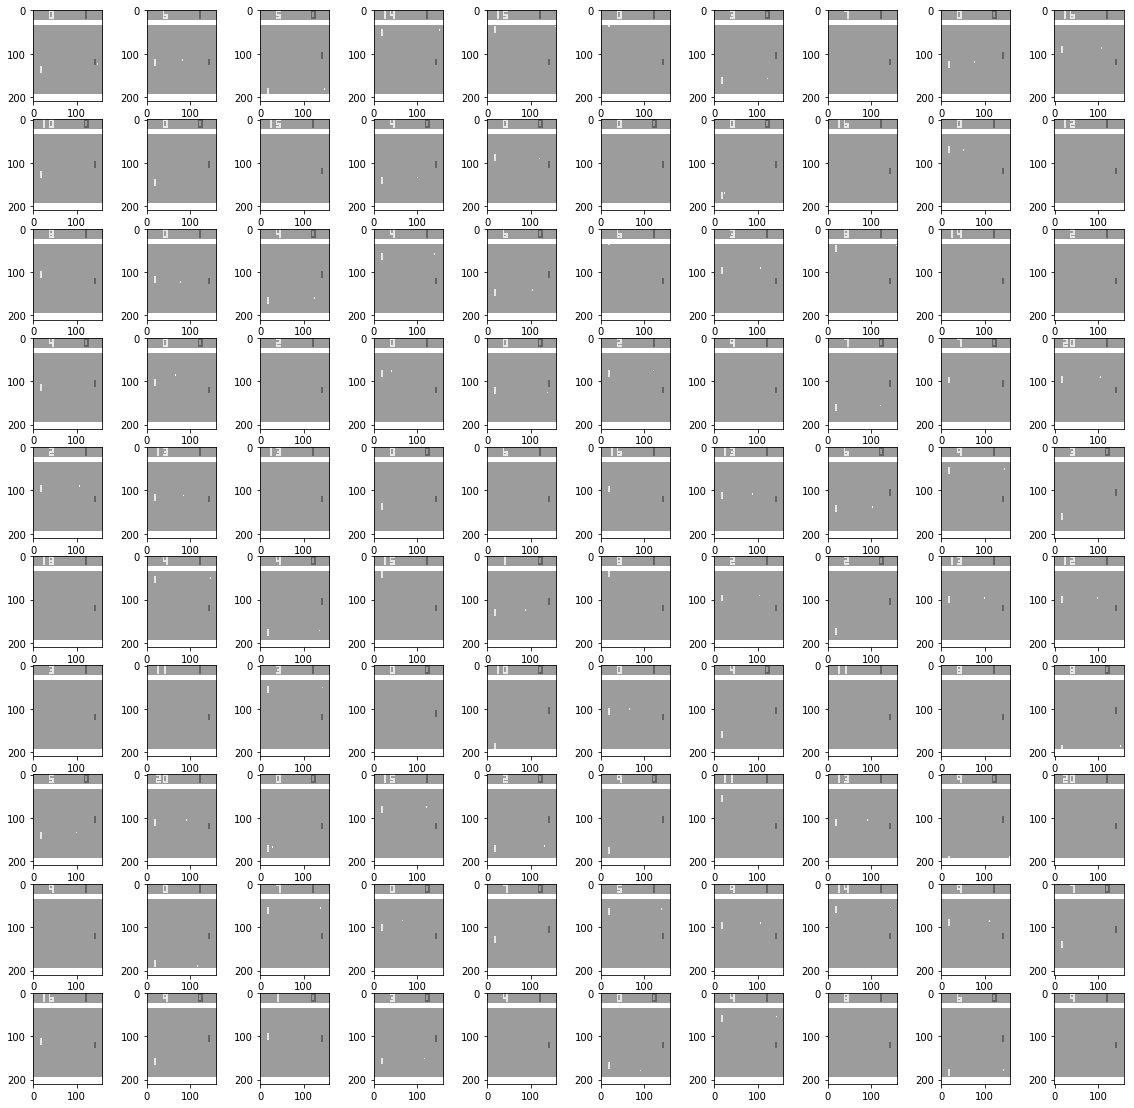

In [15]:
dataset = gym_problem.dataset(Modes.TRAIN, data_dir)
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()


fig=plt.figure(figsize=(20, 80))
columns = 10
rows = 40

with tf.Session() as sess:
    for inx in range(100):
        value = sess.run(next_element)
        for i in range(10):  # skipping surplus frames.
            value = sess.run(next_element)
        fig.add_subplot(rows, columns, inx+1)        
        image = value["inputs"].reshape([210,160,3])
        plt.imshow(image[:, :, 0].astype(np.float32), cmap=plt.get_cmap('gray'))
plt.show()